In [1]:
import pathlib
import pickle
import random
import re
import sys
import os

import nibabel as nib
import numpy as np
import pandas as pd
import pdb

# 1. Data preprocessing

In [2]:
# Path to the data folder. This may be different between users
# location = '/media/nehal/BLOO/NEHAL/UPENNACADS/SEM1/CISBE537/PROJECT/B3537_2018/B3537_2018/DataOriginal/'
location = '/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/CaseControl_complete'
data_path = pathlib.Path(location)
print("Datapath found")

Datapath found


### 1.1 Rename folders
We ran into some issues where the extremely deep paths and long filenames were causing errors with our ability to load the data. To correct this issue, we renamed folders by changing the second long folder name to `feature_masks`. For example,

`data/SECURE_KEY/2036311/DPm.1.2.840.113681.2863050713.1318230214.3060.1227/DPm.1.2.840.113681.2863050713.1318230214.3060`

becomes 

`data/SECURE_KEY/2036311/DPm.1.2.840.113681.2863050713.1318230214.3060.1227/feature_masks`

This does not cause any confusion or ambiguity, as both the filenames themselves, as well as the parent folders contain the same information. The directory structure within the directory given above by `location` is then:

```
location
├── 2036311
|   └── DPm.1.2.840.113681.2863050713.1318230214.3060.1227
|       └── feature_masks
|           └── feature
|               └── DPm ... .nii.gz
|               └── ...
|               └── DPm ... .nii.gz
|           └── mask
|               └── DPm ... 0_mask_win_97_sliding_97_mean.nii.gz
|               └── DPm ... _mask.nii.gz
└── ...
```

In [3]:
# # Rename folders
# for feature_dir in data_path.glob('*/*/feature/'):
#     parent_dir = feature_dir.parent
#     parent_dir.rename(parent_dir.parent / 'feature_masks')

### 1.2 Train/test splitting
We have been given data on roughly 570 patients. There is some ambiguity in the number, though, as we have case/control status on 575 patients, while we have feature maps for 569 patients. Of the 569 patients with features, 114 were cases and the remaining 455 were controls. In the context of breast cancer prediction, this means 114 of the patients eventually developed breast cancer while the others did not.

Among the patients with extracted feature maps, 533 patients had two images (corresponding to left and right breast), while the remaining 36 had an image for one side only. In consultation with Dr. Aimilia Gastounioti, we decided the most sensible approach would be to treat each image as a separate sample. Using this approach, we have 1102 total samples.

We opted for an 80/20 train/test split, a standard split fraction. This means that 455 patients are assigned to the traing set and 114 are assigned to the test set. We took care to ensure that the case/control ratio within both groups reflected the overall distributions. This can be seen below, where 20.2% of the patients assigned to the training set were cases, and 19.3% of the test set were cases. These numbers are not exactly 20%, though they make sense in light of the fact that the number of patients is not evenly divisible in the fraction we desire.

To eliminate a source of bias in our model, we did not allow patients with multiple images to have their data split between training and testing data. This means that patients with two images always had both images together, and we split the data by patients rather than by sample.

In [4]:
# Train/test split
# Get list of patients with feature maps
patients_list = [subdir.name for subdir in data_path.glob('*/') if subdir.is_dir() if not len(os.listdir(subdir))  == 0]

patientIds = [ item[0:item.find('_')]  for item in patients_list]
patientIds = (set(patientIds))
print(len(patientIds))
patientIds = patientIds - set(['shee'])
patientIds = list(patientIds)
print(len(patientIds))
# Read in case/control information
case_control_df = pd.read_excel('../controlcase.xlsx')

# Read in laterality information
laterInfo = pd.read_excel('../LateralityInfo.xlsx')

# Read in tumor presence information
tumor =  pd.read_excel('../TumorPosInfo.xlsx')


# Create a dictionary mapping patient_id to case/control status
patient_id_to_case = case_control_df[['DummyID', 'Class']].set_index('DummyID')['Class'].to_dict()


# print(set(patient_id_to_case.keys()) - set(patients_list))


# Create a dictionary mapping scanfile to case/control status
scan_to_laterality = tumor[['Scan', 'Laterality']].set_index('Scan')['Laterality'].to_dict()
patient_id_to_scan = tumor[['DummyID', 'Scan']].set_index('DummyID')['Scan'].to_dict()

# Create a dictionary mapping patient_id to case/control status
patient_id_to_laterality = laterInfo[['DummyID', 'Laterality']].set_index('DummyID')['Laterality'].to_dict()
patient_id_to_tumourtype = laterInfo[['DummyID', 'TumorBehavior']].set_index('DummyID')['TumorBehavior'].to_dict()


# patients_list = list(patient_id_to_scan.keys())

print(len(patients_list))

# Set random seed so that split can be done reproducibly

# Pick patients whose images will be in train/test sets 
# training_patients = np.random.choice(patients_list, replace=False, size=350)
# remaining_patients = [patient for patient in patients_list if patient not in training_patients]

# validation_patients = np.random.choice(remaining_patients, replace=False, size=109)
# testing_patients = [patient for patient in remaining_patients if patient not in validation_patients]

training_patients = []
testing_patients = []

for i in range(10):
    np.random.seed(i)
    du = np.random.choice(patientIds, replace=False, size=380)
    training_patients.append(du)
    dum = [patient for patient in patientIds if patient not in du]
    testing_patients.append(dum)
    
    








576
575
1148


In [5]:
# np.random.seed(28)

# testing_patients1 = np.random.choice(patientIds, replace=False, size=192)
# testing_patients = [patient for patient in patientIds if patient not in testing_patients1]
# testing_patients2 = np.random.choice(testing_patients, replace=False, size=192)
# testing_patients3 = [patient for patient in testing_patients if patient not in testing_patients2]


# training_patients1 = [patient for patient in patientIds if patient not in testing_patients1]
# training_patients2 = [patient for patient in patientIds if patient not in testing_patients2]
# training_patients3 = [patient for patient in patientIds if patient not in testing_patients3]

for i in range(10):

        # Verify the train/test split sizes
        print(f'Training patients: {len(training_patients[i])}\n'
        #       f'Validation patients: {len(validation_patients)}\n'
              f'Testing patients: {len(testing_patients[i])}')

        # Verify the relative numbers of cases and controls between training and testing
        num_training_cases = sum([patient_id_to_case[int(patient_id)] for patient_id in training_patients[i]])
        # num_validation_cases = sum([patient_id_to_case[int(patient_id)] for patient_id in validation_patients])
        num_testing_cases = sum([patient_id_to_case[int(patient_id)] for patient_id in testing_patients[i]])



        print(f'Percent cases in training data: {num_training_cases / len(training_patients[i])}\n'
        #       f'Percent cases in validation data: {num_validation_cases / len(validation_patients)}\n'
              f'Percent cases in testing data: {num_testing_cases / len(testing_patients[i])}\n')

        
        print()




Training patients: 380
Testing patients: 195
Percent cases in training data: 0.18947368421052632
Percent cases in testing data: 0.2205128205128205


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.2026315789473684
Percent cases in testing data: 0.19487179487179487


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.19736842105263158
Percent cases in testing data: 0.20512820512820512


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.18421052631578946
Percent cases in testing data: 0.23076923076923078


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.20789473684210527
Percent cases in testing data: 0.18461538461538463


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.2026315789473684
Percent cases in testing data: 0.19487179487179487


Training patients: 380
Testing patients: 195
Percent cases in training data: 0.19210526315789472
Percen

#### 1.2.1 Replicate training cases to class balance training data

### 1.3 Load and process feature maps
Below, we extract all feature maps, apply the mask, sort, and combine features into 4D arrays. Then, we normalize features first across samples then within samples, just as was performed in the code provided for us.

Throughout the process, we are very careful to ensure that features are always in correspondence with their patient_id or case/control status. 

#### 1.3.1 Load data into lists of feature dictionaries

In [5]:
train_features1 = ['*']*10
train_classes1 = ['*']*10
test_features1 = ['*']*10
test_classes1 = ['*']*10


#For control condition use both left right
#For case condition use only case side

def patient_id_list_to_features(patient_list, trFlag = False):
    features = list()
    classes = list()

    for patient_id in patient_list:
        # Get patient's case/control status
        patient_class = patient_id_to_case[int(patient_id)]
        full_patient_id = patient_id + '_L_MLO_1'

        # Iterate over potentially two samples
        sample_paths_left = data_path.glob(f'{full_patient_id}/*')

        full_patient_id = patient_id + '_R_MLO_1'

        sample_paths_right = data_path.glob(f'{full_patient_id}/*')

        sample_paths = [sample_paths_left, sample_paths_right]

        #UNCOMMENT BELOW IF ONLY WANT TO USE THE ACTUAL CASE SIDE                             
        if patient_class == 1:
          if patient_id_to_laterality[int(patient_id)] == 'Left':
                sample_paths = [sample_paths_left]#             
          else:
              sample_paths = [sample_paths_right]

        print()
        print("Processing...user id: ",patient_id, end =" ")
        for sample in sample_paths:
            for s in sample:

                s = s.parent    
                mask_path = next(s.glob('mask/*_mean.nii.gz')).as_posix()
                mask = nib.load(mask_path).get_data().T


                patient_features = dict()
                features_paths = s.glob('feature/*.nii.gz')
                for feature_path in features_paths:

                    # Load feature map and apply mask
                    feature_map = np.nan_to_num(nib.load(feature_path.as_posix()).get_data().T)


                    masked_feature_map = np.multiply(feature_map, mask)

                    # Extract the feature name from its filename. Eg: norm_win_97_sliding_97_box_counting from
                    # DPm.1.2.840.113681.2863050709.1375427076.3328_norm_win_97_sliding_97_box_counting.nii.gz
                    feature_name = re.search('(?<=_norm_).+(?=\.nii\.gz)', feature_path.name).group()  # noqa: W605
                    patient_features[feature_name] = masked_feature_map

                features.append(patient_features)
                classes.append(patient_class)
                print("added to database")
                break
                #UNCOMMENT FOR TEST
            if trFlag == False:    
                break



    return (features, classes)


for i in range(10):

    train_features1[i], train_classes1[i] = patient_id_list_to_features(training_patients[i], True)
    test_features1[i], test_classes1[i] = patient_id_list_to_features(testing_patients[i],  False)


Processing...user id:  3651576 added to database
added to database

Processing...user id:  3991494 added to database
added to database

Processing...user id:  5116990 added to database
added to database

Processing...user id:  3830123 added to database

Processing...user id:  4738248 added to database

Processing...user id:  3910050 added to database
added to database

Processing...user id:  4390055 added to database
added to database

Processing...user id:  3753494 added to database
added to database

Processing...user id:  4321596 added to database

Processing...user id:  4219396 added to database

Processing...user id:  4706357 added to database
added to database

Processing...user id:  3989484 added to database
added to database

Processing...user id:  4573124 added to database
added to database

Processing...user id:  3060223 added to database
added to database

Processing...user id:  3118333 added to database

Processing...user id:  3763712 added to database
added to database

P

Processing...user id:  5150405 added to database
added to database

Processing...user id:  4616981 added to database
added to database

Processing...user id:  3893275 added to database
added to database

Processing...user id:  3697245 added to database
added to database

Processing...user id:  3856769 added to database
added to database

Processing...user id:  4777958 added to database

Processing...user id:  4122867 added to database
added to database

Processing...user id:  4862749 added to database

Processing...user id:  3850791 added to database
added to database

Processing...user id:  4673210 added to database
added to database

Processing...user id:  3935231 added to database
added to database

Processing...user id:  3683609 added to database
added to database

Processing...user id:  75162495 added to database
added to database

Processing...user id:  75031782 added to database

Processing...user id:  4996142 added to database

Processing...user id:  4784470 added to database
a

Processing...user id:  3030311 added to database
added to database

Processing...user id:  3035534 added to database
added to database

Processing...user id:  4784135 added to database
added to database

Processing...user id:  4755172 added to database

Processing...user id:  3998005 added to database
added to database

Processing...user id:  4752856 added to database
added to database

Processing...user id:  2508626 added to database
added to database

Processing...user id:  3704408 added to database

Processing...user id:  4686177 added to database
added to database

Processing...user id:  3286603 added to database
added to database

Processing...user id:  4116596 added to database
added to database

Processing...user id:  4254842 added to database

Processing...user id:  3776250 added to database
added to database

Processing...user id:  75202481 added to database
added to database

Processing...user id:  3398917 added to database
added to database

Processing...user id:  4021359 ad

Processing...user id:  4671716 added to database

Processing...user id:  4334935 added to database

Processing...user id:  4192299 added to database

Processing...user id:  4159589 added to database

Processing...user id:  3734167 added to database

Processing...user id:  3988706 added to database

Processing...user id:  4631890 added to database

Processing...user id:  75198237 added to database

Processing...user id:  4239409 added to database

Processing...user id:  3750302 added to database

Processing...user id:  4293888 added to database

Processing...user id:  3724069 added to database

Processing...user id:  4072498 added to database

Processing...user id:  3667164 added to database

Processing...user id:  3978065 added to database

Processing...user id:  3672312 added to database

Processing...user id:  3560959 added to database

Processing...user id:  4145206 added to database

Processing...user id:  3526124 added to database

Processing...user id:  75404926 added to database

Processing...user id:  4011474 added to database

Processing...user id:  4862272 added to database

Processing...user id:  3542909 added to database

Processing...user id:  4199074 added to database

Processing...user id:  3874590 added to database

Processing...user id:  3633267 added to database

Processing...user id:  4328756 added to database

Processing...user id:  4968727 added to database

Processing...user id:  4725395 added to database

Processing...user id:  4610140 added to database

Processing...user id:  2735619 added to database

Processing...user id:  75011413 added to database

Processing...user id:  4045799 added to database

Processing...user id:  3991531 added to database

Processing...user id:  5229499 added to database

Processing...user id:  3683855 added to database

Processing...user id:  75078632 added to database

Processing...user id:  4785697 added to database

Processing...user id:  3705869 added to database

Processing...user id:  3863564 added to database

Processing...user id:  3081632 added to database
added to database

Processing...user id:  3910050 added to database
added to database

Processing...user id:  75089779 added to database
added to database

Processing...user id:  2508626 added to database
added to database

Processing...user id:  4750316 added to database
added to database

Processing...user id:  3099435 added to database
added to database

Processing...user id:  4100219 added to database

Processing...user id:  4021359 added to database
added to database

Processing...user id:  75220380 added to database
added to database

Processing...user id:  3552809 added to database
added to database

Processing...user id:  5262679 added to database
added to database

Processing...user id:  3024203 added to database
added to database

Processing...user id:  4344474 added to database
added to database

Processing...user id:  3707040 added to database
added to database

Processing...user id:  3874590 added to database
added to databa

added to database

Processing...user id:  3718412 added to database
added to database

Processing...user id:  3697245 added to database
added to database

Processing...user id:  4332316 added to database
added to database

Processing...user id:  3994135 added to database

Processing...user id:  3611239 added to database
added to database

Processing...user id:  4197195 added to database

Processing...user id:  3505902 added to database
added to database

Processing...user id:  3095479 added to database
added to database

Processing...user id:  3505043 added to database

Processing...user id:  3988706 added to database
added to database

Processing...user id:  3793140 added to database
added to database

Processing...user id:  4192299 added to database
added to database

Processing...user id:  3010258 added to database
added to database

Processing...user id:  4055700 added to database
added to database

Processing...user id:  75599043 added to database
added to database

Processing...u

added to database

Processing...user id:  4693780 added to database

Processing...user id:  3711323 added to database
added to database

Processing...user id:  4752856 added to database
added to database

Processing...user id:  3452673 added to database
added to database

Processing...user id:  4239409 added to database

Processing...user id:  75508343 added to database

Processing...user id:  3939689 added to database

Processing...user id:  3827482 added to database
added to database

Processing...user id:  3437521 added to database
added to database

Processing...user id:  3473413 added to database
added to database

Processing...user id:  3863564 added to database
added to database

Processing...user id:  75743474 added to database
added to database

Processing...user id:  75662391 added to database
added to database

Processing...user id:  3058371 added to database
added to database

Processing...user id:  4974545 added to database
added to database

Processing...user id:  4784518

Processing...user id:  4493059 added to database

Processing...user id:  4637012 added to database

Processing...user id:  4784135 added to database

Processing...user id:  3746259 added to database

Processing...user id:  3696382 added to database

Processing...user id:  75378852 added to database

Processing...user id:  4192027 added to database

Processing...user id:  3302717 added to database

Processing...user id:  3987350 added to database

Processing...user id:  4151194 added to database

Processing...user id:  75061858 added to database

Processing...user id:  4221243 added to database

Processing...user id:  4713298 added to database

Processing...user id:  4261987 added to database

Processing...user id:  3958577 added to database

Processing...user id:  4254842 added to database

Processing...user id:  4739783 added to database

Processing...user id:  3693969 added to database

Processing...user id:  4862272 added to database

Processing...user id:  3633267 added to database

Processing...user id:  3738793 added to database
added to database

Processing...user id:  3958987 added to database
added to database

Processing...user id:  3470102 added to database

Processing...user id:  3992503 added to database

Processing...user id:  75310663 added to database
added to database

Processing...user id:  4697446 added to database
added to database

Processing...user id:  4861187 added to database
added to database

Processing...user id:  3735661 added to database
added to database

Processing...user id:  4927881 added to database
added to database

Processing...user id:  3911015 added to database
added to database

Processing...user id:  4752856 added to database
added to database

Processing...user id:  4116596 added to database
added to database

Processing...user id:  75102038 added to database

Processing...user id:  75591775 added to database
added to database

Processing...user id:  3704408 added to database

Processing...user id:  4116583 added to database


Processing...user id:  4926950 added to database
added to database

Processing...user id:  3561180 added to database

Processing...user id:  4782708 added to database
added to database

Processing...user id:  3816904 added to database
added to database

Processing...user id:  3086416 added to database
added to database

Processing...user id:  3575394 added to database
added to database

Processing...user id:  4348183 added to database
added to database

Processing...user id:  4738248 added to database

Processing...user id:  3024203 added to database
added to database

Processing...user id:  4293341 added to database
added to database

Processing...user id:  3850791 added to database
added to database

Processing...user id:  5104477 added to database
added to database

Processing...user id:  75625569 added to database
added to database

Processing...user id:  4192299 added to database
added to database

Processing...user id:  4219396 added to database

Processing...user id:  75162495 a

Processing...user id:  75054699 added to database
added to database

Processing...user id:  4375790 added to database
added to database

Processing...user id:  3742189 added to database
added to database

Processing...user id:  3092816 added to database
added to database

Processing...user id:  4180217 added to database
added to database

Processing...user id:  3909103 added to database
added to database

Processing...user id:  4145417 added to database
added to database

Processing...user id:  2065661 added to database

Processing...user id:  75310150 added to database

Processing...user id:  4796411 added to database
added to database

Processing...user id:  3805311 added to database

Processing...user id:  4940134 added to database

Processing...user id:  4911083 added to database
added to database

Processing...user id:  3822882 added to database
added to database

Processing...user id:  75011413 added to database

Processing...user id:  3799643 added to database
added to database


Processing...user id:  4158965 added to database

Processing...user id:  3893999 added to database

Processing...user id:  3718412 added to database

Processing...user id:  3670539 added to database

Processing...user id:  4259081 added to database

Processing...user id:  4169249 added to database

Processing...user id:  3636151 added to database

Processing...user id:  4704730 added to database

Processing...user id:  4893741 added to database

Processing...user id:  3273415 added to database

Processing...user id:  4024021 added to database

Processing...user id:  4162562 added to database

Processing...user id:  3099435 added to database

Processing...user id:  4023453 added to database

Processing...user id:  4632317 added to database

Processing...user id:  4157460 added to database

Processing...user id:  3830123 added to database

Processing...user id:  4747085 added to database

Processing...user id:  4384107 added to database

Processing...user id:  75599043 added to database


Processing...user id:  4159589 added to database
added to database

Processing...user id:  3080667 added to database
added to database

Processing...user id:  3960393 added to database
added to database

Processing...user id:  3004495 added to database
added to database

Processing...user id:  3002225 added to database
added to database

Processing...user id:  4866981 added to database
added to database

Processing...user id:  4917145 added to database
added to database

Processing...user id:  4300626 added to database
added to database

Processing...user id:  3850791 added to database
added to database

Processing...user id:  3938157 added to database
added to database

Processing...user id:  3939689 added to database

Processing...user id:  4616981 added to database
added to database

Processing...user id:  3746259 added to database
added to database

Processing...user id:  4192027 added to database
added to database

Processing...user id:  3955782 added to database
added to database

added to database

Processing...user id:  75105625 added to database
added to database

Processing...user id:  3568851 added to database

Processing...user id:  3416325 added to database
added to database

Processing...user id:  4721660 added to database
added to database

Processing...user id:  4750316 added to database
added to database

Processing...user id:  3759484 added to database

Processing...user id:  3682750 added to database
added to database

Processing...user id:  4792592 added to database
added to database

Processing...user id:  3827482 added to database
added to database

Processing...user id:  4814359 added to database
added to database

Processing...user id:  3583703 added to database
added to database

Processing...user id:  4241190 added to database
added to database

Processing...user id:  4137946 added to database
added to database

Processing...user id:  3487023 added to database
added to database

Processing...user id:  5303891 added to database
added to databa

added to database

Processing...user id:  4145417 added to database
added to database

Processing...user id:  4706357 added to database
added to database

Processing...user id:  4693780 added to database

Processing...user id:  3505043 added to database

Processing...user id:  4868849 added to database
added to database

Processing...user id:  75620665 added to database
added to database

Processing...user id:  75179163 added to database

Processing...user id:  4247983 added to database
added to database

Processing...user id:  4744479 added to database
added to database

Processing...user id:  5174727 added to database
added to database

Processing...user id:  3012245 added to database

Processing...user id:  4659339 added to database
added to database

Processing...user id:  4686177 added to database
added to database

Processing...user id:  3954234 added to database
added to database

Processing...user id:  3537959 added to database
added to database

Processing...user id:  3991742 

Processing...user id:  5136613 added to database

Processing...user id:  3085423 added to database

Processing...user id:  2972511 added to database

Processing...user id:  4180217 added to database

Processing...user id:  4337647 added to database

Processing...user id:  4197195 added to database

Processing...user id:  4614952 added to database

Processing...user id:  3972328 added to database

Processing...user id:  3095624 added to database

Processing...user id:  3807494 added to database

Processing...user id:  5170689 added to database

Processing...user id:  3086416 added to database

Processing...user id:  3939739 added to database

Processing...user id:  4777958 added to database

Processing...user id:  3894643 added to database

Processing...user id:  5267522 added to database

Processing...user id:  3904376 added to database

Processing...user id:  4876628 added to database

Processing...user id:  4332316 added to database

Processing...user id:  4763490 added to database



Processing...user id:  3594665 added to database
added to database

Processing...user id:  4118822 added to database
added to database

Processing...user id:  4379837 added to database
added to database

Processing...user id:  4721660 added to database
added to database

Processing...user id:  3584875 added to database

Processing...user id:  4195237 added to database
added to database

Processing...user id:  4814359 added to database
added to database

Processing...user id:  3448812 added to database
added to database

Processing...user id:  3938157 added to database
added to database

Processing...user id:  3822882 added to database
added to database

Processing...user id:  4532650 added to database
added to database

Processing...user id:  3960393 added to database
added to database

Processing...user id:  4021359 added to database
added to database

Processing...user id:  3633267 added to database
added to database

Processing...user id:  3095479 added to database
added to database

added to database

Processing...user id:  4192299 added to database
added to database

Processing...user id:  3939739 added to database

Processing...user id:  3799128 added to database
added to database

Processing...user id:  4625615 added to database

Processing...user id:  5285619 added to database
added to database

Processing...user id:  5174727 added to database
added to database

Processing...user id:  3805311 added to database

Processing...user id:  4686177 added to database
added to database

Processing...user id:  3066391 added to database

Processing...user id:  4618555 added to database
added to database

Processing...user id:  3972328 added to database
added to database

Processing...user id:  4055700 added to database
added to database

Processing...user id:  3031231 added to database
added to database

Processing...user id:  4191288 added to database
added to database

Processing...user id:  4154124 added to database

Processing...user id:  75054699 added to database
a

added to database

Processing...user id:  4159589 added to database
added to database

Processing...user id:  4012498 added to database
added to database

Processing...user id:  3670539 added to database
added to database

Processing...user id:  4390055 added to database
added to database

Processing...user id:  4776250 added to database

Processing...user id:  4819120 added to database
added to database

Processing...user id:  4146933 added to database
added to database

Processing...user id:  4197195 added to database

Processing...user id:  3061387 added to database

Processing...user id:  3984028 added to database
added to database

Processing...user id:  75102038 added to database

Processing...user id:  75758233 added to database
added to database

Processing...user id:  3502901 added to database

Processing...user id:  3971519 added to database
added to database

Processing...user id:  3831694 added to database
added to database

Processing...user id:  3711323 added to database


Processing...user id:  5220173 added to database

Processing...user id:  4202053 added to database

Processing...user id:  75162495 added to database

Processing...user id:  3989500 added to database

Processing...user id:  3531430 added to database

Processing...user id:  4720176 added to database

Processing...user id:  4293341 added to database

Processing...user id:  4750069 added to database

Processing...user id:  75015893 added to database

Processing...user id:  3452673 added to database

Processing...user id:  4884434 added to database

Processing...user id:  3738793 added to database

Processing...user id:  4219396 added to database

Processing...user id:  3470848 added to database

Processing...user id:  4341451 added to database

Processing...user id:  3514862 added to database

Processing...user id:  3877035 added to database

Processing...user id:  3097480 added to database

Processing...user id:  3773408 added to database

Processing...user id:  5271905 added to database

Processing...user id:  3746889 added to database
added to database

Processing...user id:  4414386 added to database
added to database

Processing...user id:  3086416 added to database
added to database

Processing...user id:  4765262 added to database
added to database

Processing...user id:  75406045 added to database

Processing...user id:  4145206 added to database
added to database

Processing...user id:  4653823 added to database
added to database

Processing...user id:  3010258 added to database
added to database

Processing...user id:  4024021 added to database
added to database

Processing...user id:  3998005 added to database
added to database

Processing...user id:  4205003 added to database
added to database

Processing...user id:  3759484 added to database

Processing...user id:  4697446 added to database
added to database

Processing...user id:  4777958 added to database

Processing...user id:  4328468 added to database
added to database

Processing...user id:  75105625 a

added to database

Processing...user id:  4341451 added to database
added to database

Processing...user id:  4107377 added to database
added to database

Processing...user id:  3994079 added to database
added to database

Processing...user id:  4197302 added to database
added to database

Processing...user id:  75010308 added to database
added to database

Processing...user id:  4784518 added to database
added to database

Processing...user id:  4254842 added to database

Processing...user id:  3504934 added to database
added to database

Processing...user id:  4111492 added to database

Processing...user id:  3877035 added to database
added to database

Processing...user id:  4023453 added to database
added to database

Processing...user id:  4463904 added to database
added to database

Processing...user id:  3672312 added to database
added to database

Processing...user id:  3302717 added to database
added to database

Processing...user id:  3868166 added to database
added to databa

Processing...user id:  2735619 added to database

Processing...user id:  4348995 added to database
added to database

Processing...user id:  5120107 added to database
added to database

Processing...user id:  3561065 added to database
added to database

Processing...user id:  3095479 added to database
added to database

Processing...user id:  4974545 added to database
added to database

Processing...user id:  3850767 added to database
added to database

Processing...user id:  4911083 added to database
added to database

Processing...user id:  3487023 added to database
added to database

Processing...user id:  3058371 added to database
added to database

Processing...user id:  4625615 added to database

Processing...user id:  75031782 added to database

Processing...user id:  4927881 added to database
added to database

Processing...user id:  3076407 added to database
added to database

Processing...user id:  4586824 added to database
added to database

Processing...user id:  3738793 ad

Processing...user id:  3724503 added to database

Processing...user id:  4191481 added to database

Processing...user id:  4116583 added to database

Processing...user id:  4247983 added to database

Processing...user id:  75788196 added to database

Processing...user id:  3755174 added to database

Processing...user id:  3816904 added to database

Processing...user id:  3030311 added to database

Processing...user id:  4847986 added to database

Processing...user id:  3622446 added to database

Processing...user id:  5103723 added to database

Processing...user id:  3552809 added to database

Processing...user id:  3118333 added to database

Processing...user id:  4170077 added to database

Processing...user id:  4840005 added to database

Processing...user id:  3004495 added to database

Processing...user id:  3844729 added to database

Processing...user id:  3468063 added to database

Processing...user id:  4202053 added to database

Processing...user id:  4653024 added to database


added to database

Processing...user id:  3932266 added to database
added to database

Processing...user id:  4840005 added to database
added to database

Processing...user id:  4698039 added to database
added to database

Processing...user id:  75758233 added to database
added to database

Processing...user id:  75481020 added to database
added to database

Processing...user id:  3505043 added to database

Processing...user id:  3826878 added to database
added to database

Processing...user id:  3997047 added to database
added to database

Processing...user id:  3972328 added to database
added to database

Processing...user id:  4844646 added to database
added to database

Processing...user id:  3878539 added to database
added to database

Processing...user id:  75620665 added to database
added to database

Processing...user id:  3856769 added to database
added to database

Processing...user id:  75179163 added to database

Processing...user id:  3075958 added to database
added to dat

Processing...user id:  75625569 added to database
added to database

Processing...user id:  4337647 added to database

Processing...user id:  4323061 added to database
added to database

Processing...user id:  5135741 added to database
added to database

Processing...user id:  3688286 added to database
added to database

Processing...user id:  4204128 added to database

Processing...user id:  3302717 added to database
added to database

Processing...user id:  5170689 added to database
added to database

Processing...user id:  4847986 added to database

Processing...user id:  3805311 added to database

Processing...user id:  75162495 added to database
added to database

Processing...user id:  3724503 added to database
added to database

Processing...user id:  4861187 added to database
added to database

Processing...user id:  4862749 added to database

Processing...user id:  3742223 added to database
added to database

Processing...user id:  3542909 added to database

Processing...user 

Processing...user id:  3024203 added to database
added to database

Processing...user id:  4577494 added to database
added to database

Processing...user id:  4011474 added to database
added to database

Processing...user id:  4295722 added to database
added to database

Processing...user id:  3844729 added to database
added to database

Processing...user id:  4744479 added to database
added to database

Processing...user id:  3448812 added to database
added to database

Processing...user id:  5262679 added to database
added to database

Processing...user id:  3746259 added to database
added to database

Processing...user id:  4331945 added to database

Processing...user id:  3099435 added to database
added to database

Processing...user id:  3085423 added to database
added to database

Processing...user id:  4573124 added to database
added to database

Processing...user id:  4610140 added to database
added to database

Processing...user id:  3905064 added to database
added to database

Processing...user id:  3031231 added to database

Processing...user id:  3639059 added to database

Processing...user id:  4375790 added to database

Processing...user id:  3909103 added to database

Processing...user id:  4684239 added to database

Processing...user id:  75135863 added to database

Processing...user id:  4776250 added to database

Processing...user id:  4625615 added to database

Processing...user id:  3681064 added to database

Processing...user id:  4414386 added to database

Processing...user id:  4819120 added to database

Processing...user id:  4866981 added to database

Processing...user id:  3058260 added to database

Processing...user id:  4653823 added to database

Processing...user id:  5248457 added to database

Processing...user id:  4328468 added to database

Processing...user id:  75023610 added to database

Processing...user id:  4021359 added to database

Processing...user id:  3670416 added to database

Processing...user id:  4699307 added to database

Processing...user id:  3888798 added to database

Processing...user id:  3304281 added to database

Processing...user id:  4146610 added to database

Processing...user id:  3561065 added to database
added to database

Processing...user id:  3992503 added to database

Processing...user id:  4725395 added to database
added to database

Processing...user id:  3642926 added to database
added to database

Processing...user id:  3992006 added to database

Processing...user id:  5103723 added to database
added to database

Processing...user id:  3742189 added to database
added to database

Processing...user id:  75649563 added to database

Processing...user id:  4145206 added to database
added to database

Processing...user id:  3584643 added to database
added to database

Processing...user id:  75764463 added to database
added to database

Processing...user id:  75150283 added to database
added to database

Processing...user id:  4180217 added to database
added to database

Processing...user

Processing...user id:  4738248 added to database

Processing...user id:  4616981 added to database
added to database

Processing...user id:  5170689 added to database
added to database

Processing...user id:  75105625 added to database
added to database

Processing...user id:  5285619 added to database
added to database

Processing...user id:  2043890 added to database
added to database

Processing...user id:  4241190 added to database
added to database

Processing...user id:  4373031 added to database
added to database

Processing...user id:  3092816 added to database
added to database

Processing...user id:  75252316 added to database
added to database

Processing...user id:  75201009 added to database

Processing...user id:  4940134 added to database

Processing...user id:  4768115 added to database
added to database

Processing...user id:  3448812 added to database
added to database

Processing...user id:  3683855 added to database
added to database

Processing...user id:  4704730 

added to database

Processing...user id:  3302717 added to database
added to database

Processing...user id:  4238732 added to database
added to database

Processing...user id:  3282831 added to database

Processing...user id:  75310663 added to database
added to database

Processing...user id:  3401550 added to database
added to database

Processing...user id:  4686177 added to database
added to database

Processing...user id:  3002450 added to database
added to database

Processing...user id:  3738793 added to database
added to database

Processing...user id:  4292723 added to database
added to database

Processing...user id:  3502901 added to database

Processing...user id:  4493059 added to database

Processing...user id:  3594665 added to database
added to database

Processing...user id:  3622446 added to database

Processing...user id:  5303891 added to database
added to database

Processing...user id:  4784470 added to database
added to database

Processing...user id:  5189926 a

Processing...user id:  3984028 added to database

Processing...user id:  3734167 added to database

Processing...user id:  4558166 added to database

Processing...user id:  4958082 added to database

Processing...user id:  4784518 added to database

Processing...user id:  4885279 added to database

Processing...user id:  4796854 added to database

Processing...user id:  3667164 added to database

Processing...user id:  3978065 added to database

Processing...user id:  4421306 added to database

Processing...user id:  75144949 added to database

Processing...user id:  3672312 added to database

Processing...user id:  75662391 added to database

Processing...user id:  3072147 added to database

Processing...user id:  3778253 added to database

Processing...user id:  75176109 added to database

Processing...user id:  4118822 added to database

Processing...user id:  3921884 added to database

Processing...user id:  4914217 added to database

Processing...user id:  3031231 added to databas

Processing...user id:  3561180 added to database

Processing...user id:  4328756 added to database

Processing...user id:  3473413 added to database

Processing...user id:  4071507 added to database

Processing...user id:  4610140 added to database

Processing...user id:  4116596 added to database

Processing...user id:  2735619 added to database

Processing...user id:  3688286 added to database

Processing...user id:  75220380 added to database

Processing...user id:  4297664 added to database

Processing...user id:  4045799 added to database

Processing...user id:  4295722 added to database

Processing...user id:  75002153 added to database

Processing...user id:  4379837 added to database

Processing...user id:  3705869 added to database

Processing...user id:  3863564 added to database

Processing...user id:  5126518 added to database

Processing...user id:  3015352 added to database

Processing...user id:  3960393 added to database

Processing...user id:  3882622 added to database

Processing...user id:  3998005 added to database
added to database

Processing...user id:  75261565 added to database
added to database

Processing...user id:  3080667 added to database
added to database

Processing...user id:  4197504 added to database
added to database

Processing...user id:  3707040 added to database
added to database

Processing...user id:  5116990 added to database
added to database

Processing...user id:  3097480 added to database
added to database

Processing...user id:  3149770 added to database

Processing...user id:  3844729 added to database
added to database

Processing...user id:  5170689 added to database
added to database

Processing...user id:  5138460 added to database
added to database

Processing...user id:  3960393 added to database
added to database

Processing...user id:  3633267 added to database
added to database

Processing...user id:  4042738 added to database

Processing...user id:  75310663 added to database
added to database

Processing...u

added to database

Processing...user id:  4960441 added to database
added to database

Processing...user id:  3688286 added to database
added to database

Processing...user id:  3932266 added to database
added to database

Processing...user id:  2036311 added to database
added to database

Processing...user id:  3704408 added to database

Processing...user id:  4258244 added to database
added to database

Processing...user id:  3683609 added to database
added to database

Processing...user id:  3850791 added to database
added to database

Processing...user id:  3911015 added to database
added to database

Processing...user id:  4384107 added to database
added to database

Processing...user id:  3742189 added to database
added to database

Processing...user id:  4947709 added to database
added to database

Processing...user id:  75078632 added to database
added to database

Processing...user id:  3746889 added to database
added to database

Processing...user id:  4293888 added to databa

Processing...user id:  4927881 added to database
added to database

Processing...user id:  75309377 added to database
added to database

Processing...user id:  4379091 added to database
added to database

Processing...user id:  4321596 added to database

Processing...user id:  3822365 added to database
added to database

Processing...user id:  3958577 added to database
added to database

Processing...user id:  4375790 added to database
added to database

Processing...user id:  3015352 added to database
added to database

Processing...user id:  3735661 added to database
added to database

Processing...user id:  3462128 added to database
added to database

Processing...user id:  3469862 added to database
added to database

Processing...user id:  4496252 added to database
added to database

Processing...user id:  4154124 added to database

Processing...user id:  4697854 added to database
added to database

Processing...user id:  75788196 added to database
added to database

Processing...u

Processing...user id:  4784135 added to database

Processing...user id:  75481020 added to database

Processing...user id:  4157460 added to database

Processing...user id:  75179163 added to database

Processing...user id:  4706357 added to database

Processing...user id:  3470102 added to database

Processing...user id:  5265645 added to database

Processing...user id:  3010258 added to database

Processing...user id:  3568851 added to database

Processing...user id:  3696382 added to database

Processing...user id:  75378852 added to database

Processing...user id:  4192027 added to database

Processing...user id:  3987350 added to database

Processing...user id:  4392342 added to database

Processing...user id:  4736219 added to database

Processing...user id:  4204128 added to database

Processing...user id:  4151194 added to database

Processing...user id:  4221243 added to database

Processing...user id:  4713298 added to database

Processing...user id:  4011474 added to databas

added to database

Processing...user id:  3007591 added to database
added to database

Processing...user id:  4180217 added to database
added to database

Processing...user id:  3998005 added to database
added to database

Processing...user id:  3273415 added to database
added to database

Processing...user id:  75252316 added to database
added to database

Processing...user id:  3715835 added to database

Processing...user id:  3398917 added to database
added to database

Processing...user id:  3993843 added to database
added to database

Processing...user id:  3696382 added to database
added to database

Processing...user id:  4865563 added to database
added to database

Processing...user id:  4750069 added to database
added to database

Processing...user id:  3099435 added to database
added to database

Processing...user id:  3750302 added to database

Processing...user id:  3929030 added to database
added to database

Processing...user id:  3009162 added to database

Processing...u

added to database

Processing...user id:  75310663 added to database
added to database

Processing...user id:  4821439 added to database

Processing...user id:  4421306 added to database

Processing...user id:  5271905 added to database
added to database

Processing...user id:  4118822 added to database
added to database

Processing...user id:  75508343 added to database

Processing...user id:  4021359 added to database
added to database

Processing...user id:  3031231 added to database
added to database

Processing...user id:  3537959 added to database
added to database

Processing...user id:  4145206 added to database
added to database

Processing...user id:  3968730 added to database
added to database

Processing...user id:  4827853 added to database
added to database

Processing...user id:  75625569 added to database
added to database

Processing...user id:  3903873 added to database

Processing...user id:  3015352 added to database
added to database

Processing...user id:  4459384

Processing...user id:  4159589 added to database
added to database

Processing...user id:  4616981 added to database
added to database

Processing...user id:  4072498 added to database
added to database

Processing...user id:  3688286 added to database
added to database

Processing...user id:  3850767 added to database
added to database

Processing...user id:  3971519 added to database
added to database

Processing...user id:  3651576 added to database
added to database

Processing...user id:  3955782 added to database
added to database

Processing...user id:  3793140 added to database
added to database

Processing...user id:  4750316 added to database
added to database

Processing...user id:  4630008 added to database
added to database

Processing...user id:  4023453 added to database
added to database

Processing...user id:  4713298 added to database
added to database

Processing...user id:  3844729 added to database
added to database

Processing...user id:  75797400 added to databas

Processing...user id:  3878539 added to database

Processing...user id:  3954234 added to database

Processing...user id:  5120107 added to database

Processing...user id:  3697245 added to database

Processing...user id:  4269929 added to database

Processing...user id:  4493059 added to database

Processing...user id:  75017968 added to database

Processing...user id:  3066391 added to database

Processing...user id:  75481020 added to database

Processing...user id:  4157460 added to database

Processing...user id:  4706357 added to database

Processing...user id:  3746259 added to database

Processing...user id:  3831694 added to database

Processing...user id:  4384107 added to database

Processing...user id:  5104477 added to database

Processing...user id:  3470102 added to database

Processing...user id:  3010258 added to database

Processing...user id:  3868166 added to database

Processing...user id:  3511811 added to database

Processing...user id:  4121063 added to database

In [6]:
train_features, train_classes=train_features1, train_classes1 
# validation_features, validation_classes = validation_features1, validation_classes1 
test_features, test_classes = test_features1, test_classes1

In [7]:
len(train_classes[9])

681

In [8]:
len(train_classes[0]), len(test_classes[0])

(685, 195)

In [33]:
sum(train_classes[0]) / len(train_classes[0])


0.10510948905109489

In [34]:
sum(test_classes[0]) / len(test_classes[0])

0.2205128205128205

#### 1.3.2 Combine the data into 4D arrays
Very importantly, ensure that the features are always ordered the same way for every sample.

In [9]:
# Save the data in 4D arrays

# Create an ordered list of feature names to ensure they are in the same
# order for every sample in the training and testing data
train_data = ["*"]*10
test_data = ["*"]*10

for i in range(10):
#     print(i)
    ordered_feature_names = sorted(train_features[i][0].keys())

    # Save the data in 4D arrays
    train_data[i] = np.zeros((len(train_features[i]), 34, 26, 29))
    # validation_data = np.zeros((len(validation_features), 34, 26, 29))
    test_data[i] = np.zeros((len(test_features[i]), 34, 26, 29))

    
    for sample_number, sample_dict in enumerate(train_features[i]):
        for feature_number, feature_name in enumerate(ordered_feature_names):
            # Crop images to all be 34 x 26. Some are originally larger at 42 x 37
            train_data[i][sample_number, :, :, feature_number] = sample_dict[feature_name][0:34, 0:26]

    # for sample_number, sample_dict in enumerate(validation_features):
    #     for feature_number, feature_name in enumerate(ordered_feature_names):
    #         # Crop images to all be 34 x 26. Some are originally larger at 42 x 37
    #         validation_data[sample_number, :, :, feature_number] = sample_dict[feature_name][0:34, 0:26]

    for sample_number, sample_dict in enumerate(test_features[i]):
        for feature_number, feature_name in enumerate(ordered_feature_names):
            # Crop images to all be 34 x 26. Some are originally larger at 42 x 37
            test_data[i][sample_number, :, :, feature_number] = sample_dict[feature_name][0:34, 0:26]

    # Convert label lists to numpy arrays
    train_classes[i] = np.asarray(train_classes[i])
    # validation_classes = np.asarray(validation_classes)
    test_classes[i] = np.asarray(test_classes[i])

sample_dict

In [26]:
from skimage.transform import rotate






# for i in range(3):
#     for ind in range(len(train_classes)):
#         trf = train_data[ind,:,:,:]
#         if i == 0:
#             trfA = rotate(trf, angle=np.random.uniform(-maxD, maxD))
#             augtraindata.append(trfA)
#         elif i == 1:
#             trfFlip1 = trf[:, ::-1,:]
#             augtraindata.append(trfFlip1) 
        
#         else:
#             trfFlip2 = trf[::-1,:,:]
#             augtraindata.append(trfFlip2)

caseaugtraindata = [[]]*10
controlaugtraindata = [[]]*10
augtraindata = [[]]*10
augtrainclass = [[]]*10
train_data3 = [[]]*10
train_classes3 = [[]]*10

for k in range(10):
    
    
    caseIds = np.nonzero((train_classes[k]))[0]
    controlIds = np.nonzero(1- (train_classes[k]))[0]
    maxD = 30
    caseaugtraindata[k] = []
    for i in range(1):
        for ind in caseIds:
            trf = train_data[k][ind,:,:,:]
            trfA = rotate(trf, angle=np.random.uniform(-maxD, maxD))

            caseaugtraindata[k].append(trfA)

    for ind in caseIds:
        trf = train_data[k][ind,:,:,:]
    #     trfFlip1 = rotate(trf, angle=np.random.uniform(-maxD, maxD))

        trfFlip1 = trf[:, ::-1,:]
        caseaugtraindata[k].append(trfFlip1)


    # for ind in caseIds:
    #     trf = train_data[ind,:,:,:]
    # #     trfFlip2 = rotate(trf, angle=np.random.uniform(-maxD, maxD))

    #     trfFlip2 = trf[::-1,:,:]
    #     caseaugtraindata.append(trfFlip2)

    train_data_copy = train_data[k]

    for ind in controlIds[0:400]:
        trf = train_data[k][ind,:,:,:]
        dice = np.random.uniform(0, 1)

        if dice <0.3:
            trfFlip2 = rotate(trf, angle=np.random.uniform(-maxD, maxD))
        elif dice > 0.3 and dice < 0.7:
            trfFlip2 = trf[::-1,:,:]
        else:
            trfFlip2 = trf[:,::-1,:]
        train_data_copy[ind,:,:,:] = trfFlip2


#     print(len(caseaugtraindata[k]))
#     print(len(train_data_copy))
#     print(len(train_classes2))
    
    caseaugtraindata[k] = np.asarray(caseaugtraindata[k])
    
    
    train_data2 = train_data[k]
    train_data3[k] = np.concatenate((train_data_copy,caseaugtraindata[k]), axis = 0)
    train_classes2 = train_classes[k]
    train_classes3[k] = np.concatenate((train_classes2,np.ones(len(caseIds)*2)), axis = 0)
    
# controlaugtraindata = np.asarray(controlaugtraindata)


# augtraindata = np.asarray(augtraindata)

print("Done augmentations!")
#randomly sampled from -20 to 20

# image = train_data[0,:,:,0]
# image.shape
# rotate(image, degrees)


144
685
681
154
681
685
150
683
681
140
689
683
158
679
689
154
680
679
146
685
680
148
682
685
146
684
682
152
681
684
Done augmentations!


In [21]:
caseIds

array([  0,  29,  30,  37,  52,  75, 102, 103, 120, 131, 132, 141, 148,
       151, 158, 159, 172, 185, 188, 205, 228, 239, 240, 241, 258, 269,
       272, 279, 298, 301, 306, 313, 316, 317, 322, 327, 346, 349, 366,
       375, 384, 391, 396, 397, 402, 417, 434, 445, 454, 461, 464, 467,
       481, 494, 513, 514, 515, 546, 547, 548, 555, 560, 593, 598, 601,
       604, 605, 608, 609, 614, 615, 656, 675, 676, 677, 678])

In [ ]:






# train_data2 = train_data
# train_data3 = np.concatenate((train_data2,caseaugtraindata,controlaugtraindata), axis = 0)
# train_classes2 = train_classes
# train_classes3 = np.concatenate((train_classes2,np.ones(len(caseIds)*5),np.zeros(len(controlIds))), axis = 0)

# train_data2 = train_data
# train_data3 = np.concatenate((train_data2,augtraindata), axis = 0)
# train_classes2 = train_classes
# train_classes3 = np.concatenate((train_classes2,train_classes2,train_classes2,train_classes2), axis = 0)




In [29]:
len(train_classes3[7]), len(train_data3[7])

(830, 830)

In [44]:
len(test_classes[1]), len(test_data[1])

(2, 34)

In [86]:
sum(train_classes3)/len(train_classes3)

ValueError: operands could not be broadcast together with shapes (829,) (835,) 

In [35]:
a = [[]]*10
a[0].append(3)
a[0] = 4
a


[4, [3], [3], [3], [3], [3], [3], [3], [3], [3]]

#### 1.3.3 Normalize the feature maps
As was done in the preprocessing code from the 2016 paper, we first normalize across samples, then normalize features within samples. Note that we add a term, `epsilon` to the divisors below. This is because some features are zero across all samples or across all feature_maps within sample. In these cases, we would be dividing by zero, which would introduce unwanted `nan` terms into the data.

In [37]:
epsilon = 1e-8

# Normalize the data across samples
# Combine the data and find the largest magnitude values for each feature
# full_data = np.concatenate((train_data3,validation_data, test_data))
full_data = [[]]*10

for i in range(10):
    full_data[i] = np.concatenate((train_data3[i], test_data[i]))

    max_image = np.abs(full_data[i]).max(axis=0)

    train_data3[i] = np.divide(train_data3[i], max_image + epsilon)
# validation_data = np.divide(validation_data, max_image + epsilon)
    test_data[i] = np.divide(test_data[i], max_image + epsilon)

    # Normalize feature maps within samples so that the maximum value in each is 1.
    # # This is the within-sample normalization that was performed
    # # in the preprocessing code we received from the 2016 paper
    for data_source in (train_data3[i], test_data[i]):
        for sample_number, sample in enumerate(data_source):
            for feature_number in range(29):
                feature_map = sample[:, :, feature_number]
                max_val = np.abs(feature_map).max()
                data_source[sample_number, :, :, feature_number] = np.divide(feature_map, max_val + epsilon)

    # Save the data as pickled tuples of data, labels
    training_set = (train_data3[i], train_classes3[i])
    # validation_set = (validation_data, validation_classes)
    testing_set = (test_data[i], test_classes[i])

    train_data_path = data_path.parent.joinpath('TrainTestData/train_data_split_{}.pkl'.format(i))
    # validation_data_path = data_path.parent.joinpath('validation_data_aug2.pkl')
    test_data_path = data_path.parent.joinpath('TrainTestData/test_data_split_{}.pkl'.format(i))
    print(train_data_path)
    # print(validation_data_path)
    print(test_data_path)

# DANGEROUS OPERATION, UNCOMMENT ONLY WHEN DUMPING DATA
#     with open(train_data_path, 'wb') as f:
#         pickle.dump(training_set, f)

#     with open(test_data_path, 'wb') as f:
#         pickle.dump(testing_set, f)

/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_0.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_0.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_1.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_1.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_2.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_2.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_3.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_3.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_4.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_4.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_5.pkl
/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_5.pk

# 2. Create and train CNN model

In [76]:
len(train_classes3)

1059

In [1]:
import pathlib
import pickle
import random
import re
import sys
import time


import nibabel as nib
import numpy as np
import pandas as pd
import pdb

from keras.callbacks import EarlyStopping,TensorBoard, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from keras.models import Sequential
from keras.optimizers import SGD,Adam,RMSprop,Adagrad,Nadam,Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, classification_report,auc
from keras.models import load_model
from sklearn.utils import class_weight
import pdb
from keras import initializers
import tensorflow as tf
#0
sd = 1
# set_random_seed(2)
np.random.seed(sd)
import random as rn
rn.seed(sd)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_raROC CURVEndom_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(sd)



with open('/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/train_data_split_4.pkl', 'rb') as f:
    train_data, train_labels = pickle.load(f)
train_classes = (train_labels)

# with open('/media/nehal/BLOO/NEHAL/UPENNACADS/SEM1/CISBE537/PROJECT/B3537_2018/B3537_2018/validation_data_aug.pkl', 'rb') as f:
#     validation_data, validation_labels = pickle.load(f)
# validation_classes = (validation_labels)

with open('/media/nehal/BLOO/RSNA_BreastCancer/FINAL_DATA/TrainTestData/test_data_split_4.pkl', 'rb') as f:
    test_data, test_labels = pickle.load(f)
test_classes = test_labels

# temp_data = validation_data 
# temp_classes = validation_classes

validation_data = test_data
validation_classes = test_classes

# test_data = temp_data
# test_classes = temp_classes

Ptrain_data = train_data
Ptrain_classes = train_classes

# Ptrain_data = np.concatenate((train_data,validation_data),axis = 0)
# Ptrain_classes = np.concatenate((train_classes,validation_classes),axis = 0)

print((test_classes))

ind = list(range(len(Ptrain_classes)))
random.shuffle((ind))


Ptrain_classes = Ptrain_classes[ind]
Ptrain_data = Ptrain_data[ind]
Ptrain_classes2 = to_categorical(Ptrain_classes)




indT = list(range(len(test_classes)))
random.shuffle((indT))



test_classes = test_classes[indT]
test_data = test_data[indT]

test_classes = to_categorical(test_classes)




Using TensorFlow backend.


In [12]:
# print(ind)

In [13]:
len(Ptrain_data)

837

In [14]:
len(test_labels)

194

In [ ]:
# Set numpy and TensorFlow random seeds in the hopes of making
# results reproducible. This will not be possible when using a GPU,
# as there may be asynchronous processing for which no random seed
# could account.
testauc_ = 0
num = 0
# while(testauc_ < 60):
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
datagen = ImageDataGenerator()
datagen.fit(Ptrain_data)
#166,173
num = num+1
val_datagen = ImageDataGenerator()
val_datagen.fit(validation_data)

model = Sequential([
    Conv2D(8,kernel_size=(5, 5), activation='elu',
         input_shape=(34, 26, 29),
          kernel_initializer=initializers.glorot_uniform(seed=num),
          bias_initializer=initializers.glorot_uniform(seed=num)),
    MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.4),
    Conv2D(8,kernel_size=(4, 3), activation='elu',
           kernel_initializer=initializers.glorot_uniform(seed=num),
          bias_initializer=initializers.glorot_uniform(seed=num)),
    MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.4),
    Flatten(),
    Dense(5, activation='elu',
          kernel_initializer=initializers.glorot_uniform(seed=num),
         bias_initializer=initializers.glorot_uniform(seed=num)),
    Dense(2, activation='sigmoid')
])

sgd = Adam(lr = 0.001)
model.compile(optimizer=sgd, loss='binary_crossentropy',
              metrics=['binary_accuracy'])

callback = EarlyStopping(monitor='val_binary_accuracy', min_delta=-0.1, patience=2,
                         verbose=1, mode='auto', baseline=0.8)

reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.3,
                              patience=3, min_lr=0.0001) 

board = TensorBoard(log_dir='./logs')

class_weights = class_weight.compute_class_weight('balanced', np.unique(Ptrain_classes),
                                                 Ptrain_classes)
# pdb.set_trace()

# model.fit_generator(datagen.flow(Ptrain_data, Ptrain_classes2, batch_size = 4, shuffle = True ),
# #                    steps_per_epoch = len(Ptrain_classes2) , 
#                     epochs = 15,validation_data=val_datagen.flow(validation_data, validation_classes),
#                     class_weight = class_weights)


model.fit(Ptrain_data, Ptrain_classes2, shuffle=True,batch_size = 4,
#                     callbacks=[reduce_lr],
                    epochs = 15,
                    class_weight = class_weights
#                       validation_data = (test_data,test_classes)

#                     validation_data=val_datagen.flow(validation_data, validation_classes),
#                     nb_val_samples=validation_data.shape[0]
                   )


score = model.evaluate(Ptrain_data, Ptrain_classes2)

print("Weighted train accuracy: ", score[1])
preds = model.predict(Ptrain_data)
auc_ = roc_auc_score(Ptrain_classes2, preds)
print(model.summary())
print(f"AUROC: {auc_}")

score = model.evaluate(test_data, test_classes)

print("Weighted test accuracy: ", score[1])
preds = model.predict(test_data)
testauc_ = roc_auc_score(test_classes, preds)
print(model.summary())
print(f"AUROC: {testauc_}")
#     time.sleep(150)

/home/nehal/anaconda3/envs/tf/lib/python3.6/site-packages/keras_preprocessing/image.py:1358: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (837, 34, 26, 29) (29 channels).
  ' channels).')
/home/nehal/anaconda3/envs/tf/lib/python3.6/site-packages/keras_preprocessing/image.py:1358: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 34, 26, 29) (29 channels).
  ' channels).')


In [9]:
sum(test_classes[:,1])/len(test_classes)

0.18556701030927836

In [10]:
class_weights

array([0.6975    , 1.76582278])

In [86]:
test_labels

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

Balanced Test Accuracy: 0.5275443510737629

              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       153
         1.0       0.26      0.24      0.25        42

   micro avg       0.69      0.69      0.69       195
   macro avg       0.53      0.53      0.53       195
weighted avg       0.68      0.69      0.69       195



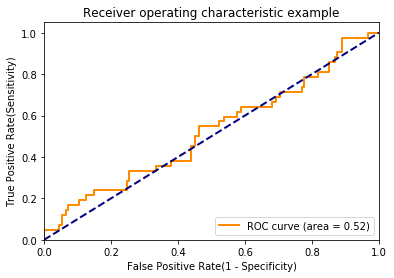

In [19]:
import matplotlib.pyplot as plt

# preds = model.predict_proba(test_data)
bal_acc = balanced_accuracy_score(test_classes[:,1], 1*(preds[:,0]<preds[:,1]))
print("Balanced Test Accuracy: {}".format(bal_acc))
print()
print(classification_report(test_classes[:,1], 1*(preds[:,0]<preds[:,1])))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_classes[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [13]:
import scipy.stats

from scipy.stats import sem, t
from scipy import mean
confidence = 0.95
data = [0.574, 0.5927, 0.580]

n = len(data)
m = mean(data)
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

print("AUROC:{} (95% confidence interval [CI]: {}, {})  ".format(m,m-h,m+h))


AUROC:0.5822333333333334 (95% confidence interval [CI]: 0.5585149127319149, 0.6059517539347519)  


In [15]:
a

15.0

In [12]:
1.0*(preds[:,0]<preds[:,1])

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [8]:
bal_acc = balanced_accuracy_score(test_classes, preds)
print(f"Balanced Accuracy: {bal_acc}")

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [16]:
# Check AUC on the training data, just to verify that the training data was learned.
score = model.evaluate(train_data, train_classes)

print("Weighted test accuracy: ", score[1])
preds = model.predict(train_data)
auc = roc_auc_score(train_classes, preds)
print(model.summary())
print(f"AUROC: {auc}")

ValueError: Error when checking target: expected dense_16 to have shape (2,) but got array with shape (1,)

In [ ]:
model.save('../model/most_recent.h5')

In [ ]:
model = load_model('../model/most_recent.h5')
